In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
import re

import collections
import seaborn as sns

In [6]:
#한글 깨짐 처리
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")

else :
    plt.rc("font", family="Malgun Gothic")

%config InlineBackend.figure_format = 'retina'

In [7]:
train = pd.read_csv("capstone_dataset/train.csv")
val = pd.read_csv("capstone_dataset/valid.csv")
test = pd.read_csv("capstone_dataset/test.csv")

In [8]:
train.head()

,id,title,body,category,label
0,AKR20191006026700004,공소시효 만료로 수배 해제 5년간 2만3천건…하루 13건꼴,공소시효가 만료돼 수배가 해제되는 사건이 하루 12∼13건꼴인 것으로 조사됐다. 6...,3,0
1,AKR20190201116900051,설 연휴 부산 병·의원 2천75곳 문 연다,이번 설 연휴 부산에서는 모두 2천75곳의 병·의원이 문을 연다. 부산시는 2일부터...,3,0
2,AKR20200731075300061,"시흥시, 청년근로자 100명에 60만원씩 복지포인트 지급","경기 시흥시는 관내 시흥청년해피기업에 근무하는 청년 근로자 100명을 선정, 1인당...",7,0
3,AKR20191220114000001,"한국당 5일째 패스트트랙法 규탄대회…""4+1, 文정권에 예산뇌물""",자유한국당 황교안 대표와 민주평화당 정동영·정의당 이정미 대표는 4일 상견례 자리에...,1,1
4,AKR20191029112900057,"울산시의원 ""시민 참여 온라인 쇼핑몰 울산몰 만들자""",경남도의회는 11일 제10호 태풍 하이선으로 낙과 피해를 본 밀양시 산내면 사과 재...,1,1


# preprocessing

In [9]:
def preprocessing(text):
    m = Mecab()
    
    cleaned_text = re.sub('[^가-힣]', ' ', text) #한글과 영어 소문자만 남기고 다른 글자 모두 제거
    tokenized_text = m.morphs(cleaned_text)
    removed_by_len_text = [token for token in tokenized_text if len(token)>1]
    return removed_by_len_text

In [10]:
train['title_token'] = train['title'].apply(preprocessing)
train['body_token'] = train['body'].apply(preprocessing)

val['title_token'] = val['title'].apply(preprocessing)
val['body_token'] = val['body'].apply(preprocessing)

In [11]:
#train['token'] = tokenized_data

body의 최대 길이 : 3232
body의 평균 길이 : 181.94978


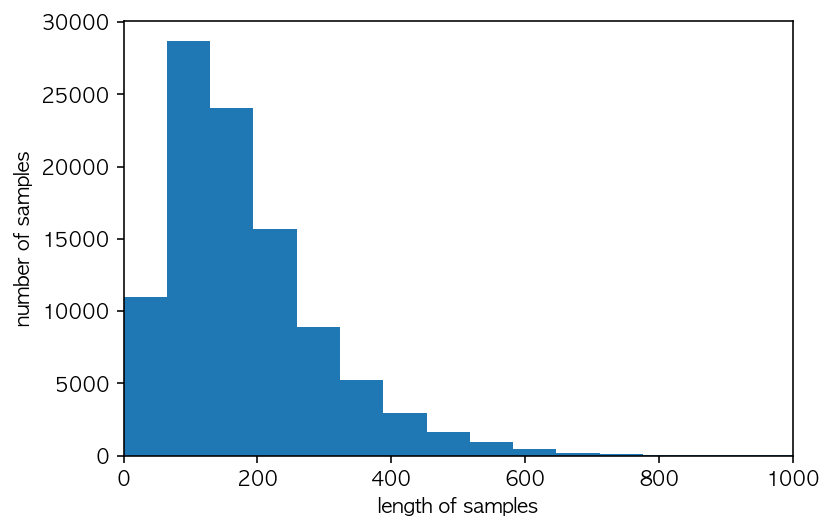

In [12]:
# body 길이 분포 확인
print('body의 최대 길이 :',max(len(review) for review in train['body_token']))
print('body의 평균 길이 :',sum(map(len, train['body_token']))/len(train['body_token']))
plt.hist([len(body) for body in train['body_token']], bins=50)
plt.xlim(0,1000)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
len_token = [len(review) for review in train['body_token']]
len_token = np.array(len_token)
np.percentile(len_token, 95) #value of padding

415.0

In [14]:
len_token = [len(title) for title in train['title_token']]
len_token = np.array(len_token)
np.percentile(len_token, 95) #value of padding

10.0

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
tokenizer = Tokenizer() 
tokenized_text = pd.concat([train.body_token,train.title_token],axis=0)
tokenizer.fit_on_texts(tokenized_text)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1

In [17]:
vocab_size

127860

In [18]:
def encoded_text(tokenizer,tokenized_data,max_len):
    encoded = tokenizer.texts_to_sequences(tokenized_data)
    padded = pad_sequences(encoded, maxlen=max_len)
    return padded

In [19]:
train_encoded_title_text = encoded_text(tokenizer,train['title_token'],10)
train_encoded_body_text = encoded_text(tokenizer,train['body_token'],415)

val_encoded_title_text = encoded_text(tokenizer,val['title_token'],10)
val_encoded_body_text = encoded_text(tokenizer,val['body_token'],415)

# FastText

In [20]:
import gensim
from gensim import models
from gensim.models import fasttext
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec, KeyedVectors

In [21]:
%%time
ft_model = fasttext.load_facebook_model('/Users/saeran/Desktop/SJU2022/캡스톤/wordembedding/fasttext_wiki.ko/wiki.ko.bin')
ft_model.build_vocab(sentences=tokenized_text, update=True)
ft_model.train(tokenized_text, total_examples=len(tokenized_text),epochs=5)

CPU times: user 44min 43s, sys: 16min 37s, total: 1h 1min 20s
Wall time: 41min 59s


In [32]:
ft_model.similar_by_word('병원')

<ipython-input-32-257080a30c13>:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ft_model.similar_by_word('병원')


[('요양병원', 0.8322166204452515),
 ('암병원', 0.824726402759552),
 ('입원병원', 0.8179007172584534),
 ('시립병원', 0.8154072165489197),
 ('차병원', 0.8124256134033203),
 ('도립병원', 0.8043469786643982),
 ('의료', 0.8013299703598022),
 ('입원', 0.8010314106941223),
 ('한림병원', 0.8006834983825684),
 ('동산병원', 0.8004926443099976)]

In [35]:
embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성

for word,index in tokenizer.word_index.items(): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in ft_model: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = ft_model[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
    else:
        print(word)
        print("word2vec에 없는 단어입니다.")
        break

<ipython-input-35-ac03a62bd625>:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in ft_model: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
<ipython-input-35-ac03a62bd625>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_vector = ft_model[word] #해당 토큰에 해당하는 vector를 불러오고


In [36]:
len(tokenizer.word_index)

127859

In [37]:
print(ft_model.wv.similar_by_word('병원'))

[('요양병원', 0.8322166204452515), ('암병원', 0.824726402759552), ('입원병원', 0.8179007172584534), ('시립병원', 0.8154072165489197), ('차병원', 0.8124256134033203), ('도립병원', 0.8043469786643982), ('의료', 0.8013299703598022), ('입원', 0.8010314106941223), ('한림병원', 0.8006834983825684), ('동산병원', 0.8004926443099976)]


In [ ]:
#임베딩 모델 저장
#ft_model.save("/Users/saeran/Desktop/SJU2022/캡스톤/wordembedding/fasttext_final.bin")

# attention (바다나우)

In [34]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # key와 value는 같음
    #1.attention score (encoder의 hidden states와 t-1 decoder의 state)
    query_expand_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(values)+self.W2(query_expand_axis))) #(batch_size, max_length, 1)
    
    #2.attention weights(softmax)
    attention_weights = tf.nn.softmax(score, axis=1) #(batch_size, max_length, 1)

    #3. attention value(어텐션 가중치, encoder hidden states)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# bi-LSTM + attention

In [38]:
import tensorflow as tf
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import ModelCheckpoint,EarlyStopping


from keras.models import Model
from keras import layers
from keras.layers import Dense, Embedding, LSTM, Concatenate, Dropout, Bidirectional
from keras import Input

from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [39]:
X_train_title, X_val_title = train_encoded_title_text, val_encoded_title_text
X_train_body, X_val_body = train_encoded_body_text, val_encoded_body_text
y_train, y_val = train.label.values, val.label.values

In [40]:
X_train_title.shape, X_val_title.shape,X_train_body.shape,X_val_body.shape, y_train.shape, y_val.shape

((100000, 10), (25000, 10), (100000, 415), (25000, 415), (100000,), (25000,))

In [41]:
X_train_title.shape, X_val_title.shape

((100000, 10), (25000, 10))

In [42]:
embedding_matrix.shape

(127860, 300)

In [32]:
#bi-lstm + attention

#title : lstm
input_title = Input(shape=(10,),name="title",dtype='int32')
embedded_title = Embedding(vocab_size,300,weights = [embedding_matrix], input_length = 10,trainable=False)(input_title)
lstm_title = Bidirectional(LSTM(64, dropout=0.2))(embedded_title)
#body: lstm + attention
input_body = Input(shape=(415,),name="body",dtype='int32')
embedded_body = Embedding(vocab_size, 300,weights = [embedding_matrix], input_length = 415,trainable=False)(input_body)
lstm_body = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_body)
lstm_body, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm_body)

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) #가중치 크기 정의
context_vector, attention_weights = attention(lstm_body, state_h) 
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)

#title + body
concatenated = layers.concatenate([lstm_title,dropout])

#layer
layer1 = Dense(10,activation='relu')(concatenated)
layer2 = Dense(5,activation='relu')(layer1)

#분류
output = Dense(1, activation='sigmoid')(layer2)

model = Model(inputs=[input_title,input_body],outputs=output)
model.summary()

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 body (InputLayer)              [(None, 415)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 10, 300)      38358000    ['title[0][0]']                  
                                                                                                  
 embedding_3 (Embedding)        (None, 415, 300)     38358000    ['body[0][0]']                   
                                                                                            

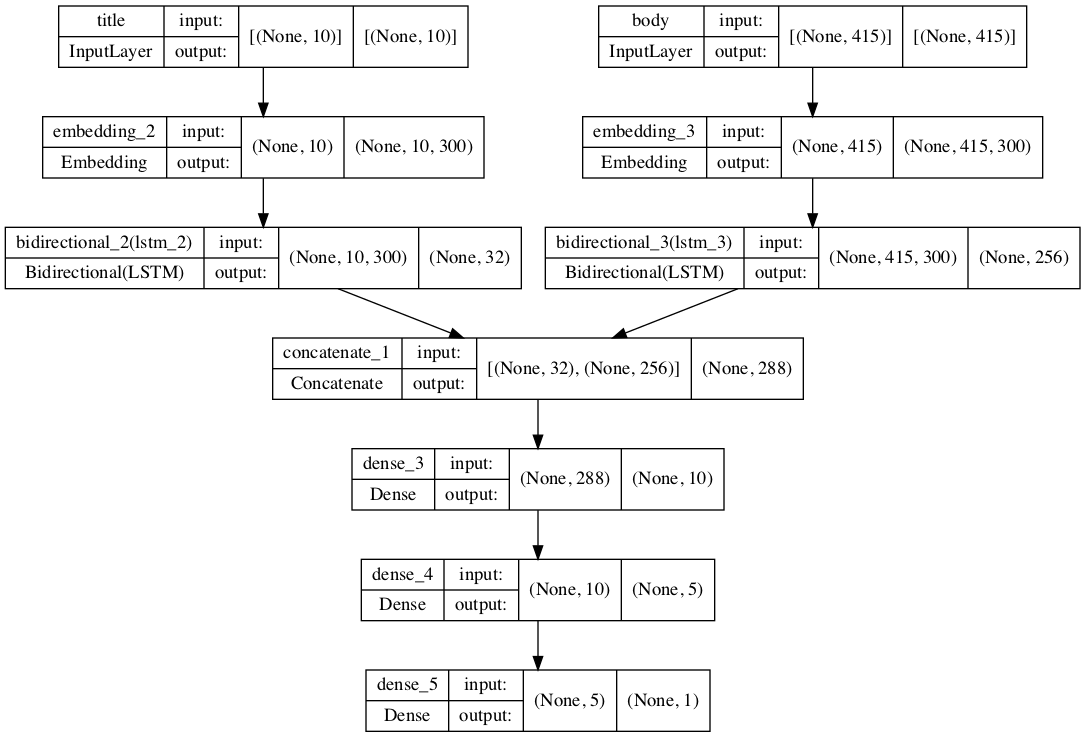

In [34]:
#model structure visualization
from tensorflow import keras
from tensorflow.keras.utils import plot_model
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit({'title':X_train_title,'body':X_train_body}, y_train, epochs=10, batch_size=256, verbose=1,callbacks=[es,mc],validation_data=[[X_val_title,X_val_body],y_val])

Epoch 1/10
244/391 [=================>............] - ETA: 8:17 - loss: 0.6936 - acc: 0.5016

In [ ]:
#Diagnostic Plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
pd.DataFrame(history.history)

In [ ]:
#Diagnostic Plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#정성적 평가
#prediction = model.predict([X_val_title,X_val_body])
#result = val.copy() #깊은 복사
#result['prediction_CNN']=prediction 
#result.to_csv('result_실험제목.csv')